This project was done by Menashe Lorenzi and Nadav Lisha. This code was generated by Chat-GPT while we instructed it on what we wanted to accomplish. 

In [1]:

# Data handling
import pandas as pd
import numpy as np

# Machine Learning
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, roc_curve, auc
from sklearn.preprocessing import label_binarize
# Initialize a dictionary to store test results
from sklearn.metrics import f1_score, precision_score, recall_score
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import roc_auc_score
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from scipy.stats import ttest_rel, wilcoxon
from sklearn.calibration import calibration_curve
from sklearn.metrics import ConfusionMatrixDisplay


# Visualization
import matplotlib.pyplot as plt
import seaborn as sns


These are the libraries we will be using for our analysis.

In [4]:

# Load the data
df = pd.read_csv(r"price_data_multicurrency.csv", parse_dates=['TRADE_TIMESTAMP'])

# Sort by time
df = df.sort_values('TRADE_TIMESTAMP')

# Drop missing values
df = df.dropna()

# Show first rows
df.head()


,TRADE_TIMESTAMP,PRICE,CURRENCY
0,2018-01-02 22:28:01.747,0.0938,EUR
1,2018-01-03 02:17:53.896,0.0876,EUR
2,2018-01-03 09:57:12.584,0.0802,AUD
3,2018-01-03 22:09:31.159,0.0692,EUR
4,2018-01-04 02:22:08.771,0.0675,EUR


This will read the csv from the location of our pc and drop all null values and sorting them by the time.

In [5]:

# Check the distribution of the currency column
df['CURRENCY'].value_counts(normalize=True)


CURRENCY
EUR    0.519018
AUD    0.330061
USD    0.150920
Name: proportion, dtype: float64

In [6]:

# Feature engineering
df['delta_price'] = df['PRICE'].diff().fillna(0)
df['delta_time'] = df['TRADE_TIMESTAMP'].diff().dt.total_seconds().fillna(0)
df['hour'] = df['TRADE_TIMESTAMP'].dt.hour
df['minute'] = df['TRADE_TIMESTAMP'].dt.minute

# Display updated data
df.head()


,TRADE_TIMESTAMP,PRICE,CURRENCY,delta_price,delta_time,hour,minute
0,2018-01-02 22:28:01.747,0.0938,EUR,0.0000,0.000,22,28
1,2018-01-03 02:17:53.896,0.0876,EUR,-0.0062,13792.149,2,17
2,2018-01-03 09:57:12.584,0.0802,AUD,-0.0074,27558.688,9,57
3,2018-01-03 22:09:31.159,0.0692,EUR,-0.0110,43938.575,22,9
4,2018-01-04 02:22:08.771,0.0675,EUR,-0.0017,15157.612,2,22


We organized the data better (Using Chat-Gpt for suggestions on the columns to add). 

In [7]:

# Stratified split
split = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
for train_idx, test_idx in split.split(df, df['CURRENCY']):
    train_set = df.iloc[train_idx]
    test_set = df.iloc[test_idx]
    
print('Train size:', len(train_set))
print('Test size:', len(test_set))


Train size: 652
Test size: 163


In [8]:

# Define features and labels
features = ['PRICE', 'delta_price', 'delta_time', 'hour', 'minute']
X_train = train_set[features]
y_train = train_set['CURRENCY']

X_test = test_set[features]
y_test = test_set['CURRENCY']

# Standardize the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)


Random Forest Accuracy: 0.99
Logistic Regression Accuracy: 0.87
SVM Accuracy: 0.96
KNN Accuracy: 0.96
Gradient Boosting Accuracy: 0.98


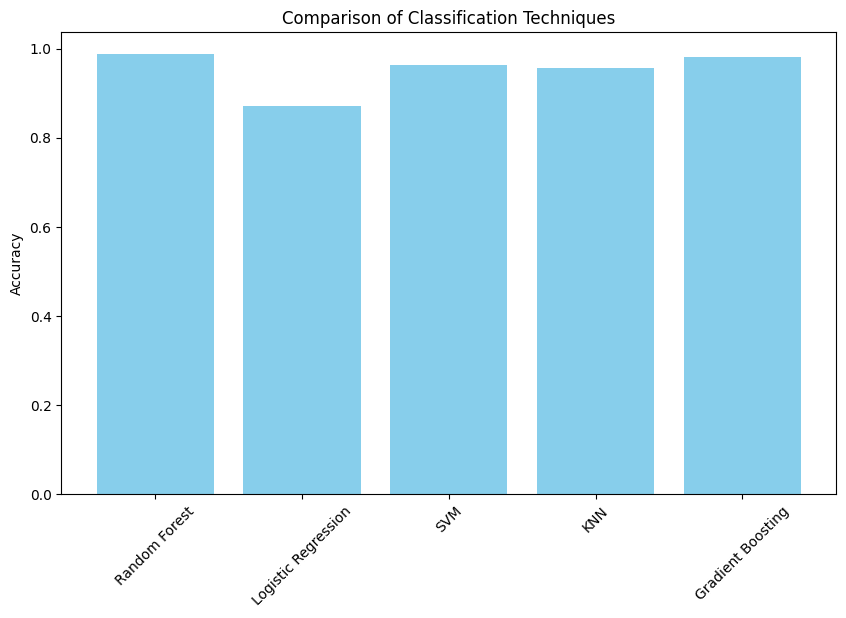

In [9]:
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, roc_curve, auc
from sklearn.preprocessing import label_binarize
# Define models
models = {
    "Random Forest": RandomForestClassifier(n_estimators=100, random_state=42),
    "Logistic Regression": LogisticRegression(max_iter=1000, random_state=42),
    "SVM": SVC(probability=True, random_state=42),
    "KNN": KNeighborsClassifier(n_neighbors=5),
    "Gradient Boosting": GradientBoostingClassifier(random_state=42)
}

# Train and evaluate each model
results = {}
for name, clf in models.items():
    clf.fit(X_train_scaled, y_train)
    y_pred = clf.predict(X_test_scaled)
    accuracy = accuracy_score(y_test, y_pred)
    results[name] = accuracy
    print(f"{name} Accuracy: {accuracy:.2f}")

# Compare results
plt.figure(figsize=(10, 6))
plt.bar(results.keys(), results.values(), color='skyblue')
plt.title("Comparison of Classification Techniques")
plt.ylabel("Accuracy")
plt.xticks(rotation=45)
plt.show()

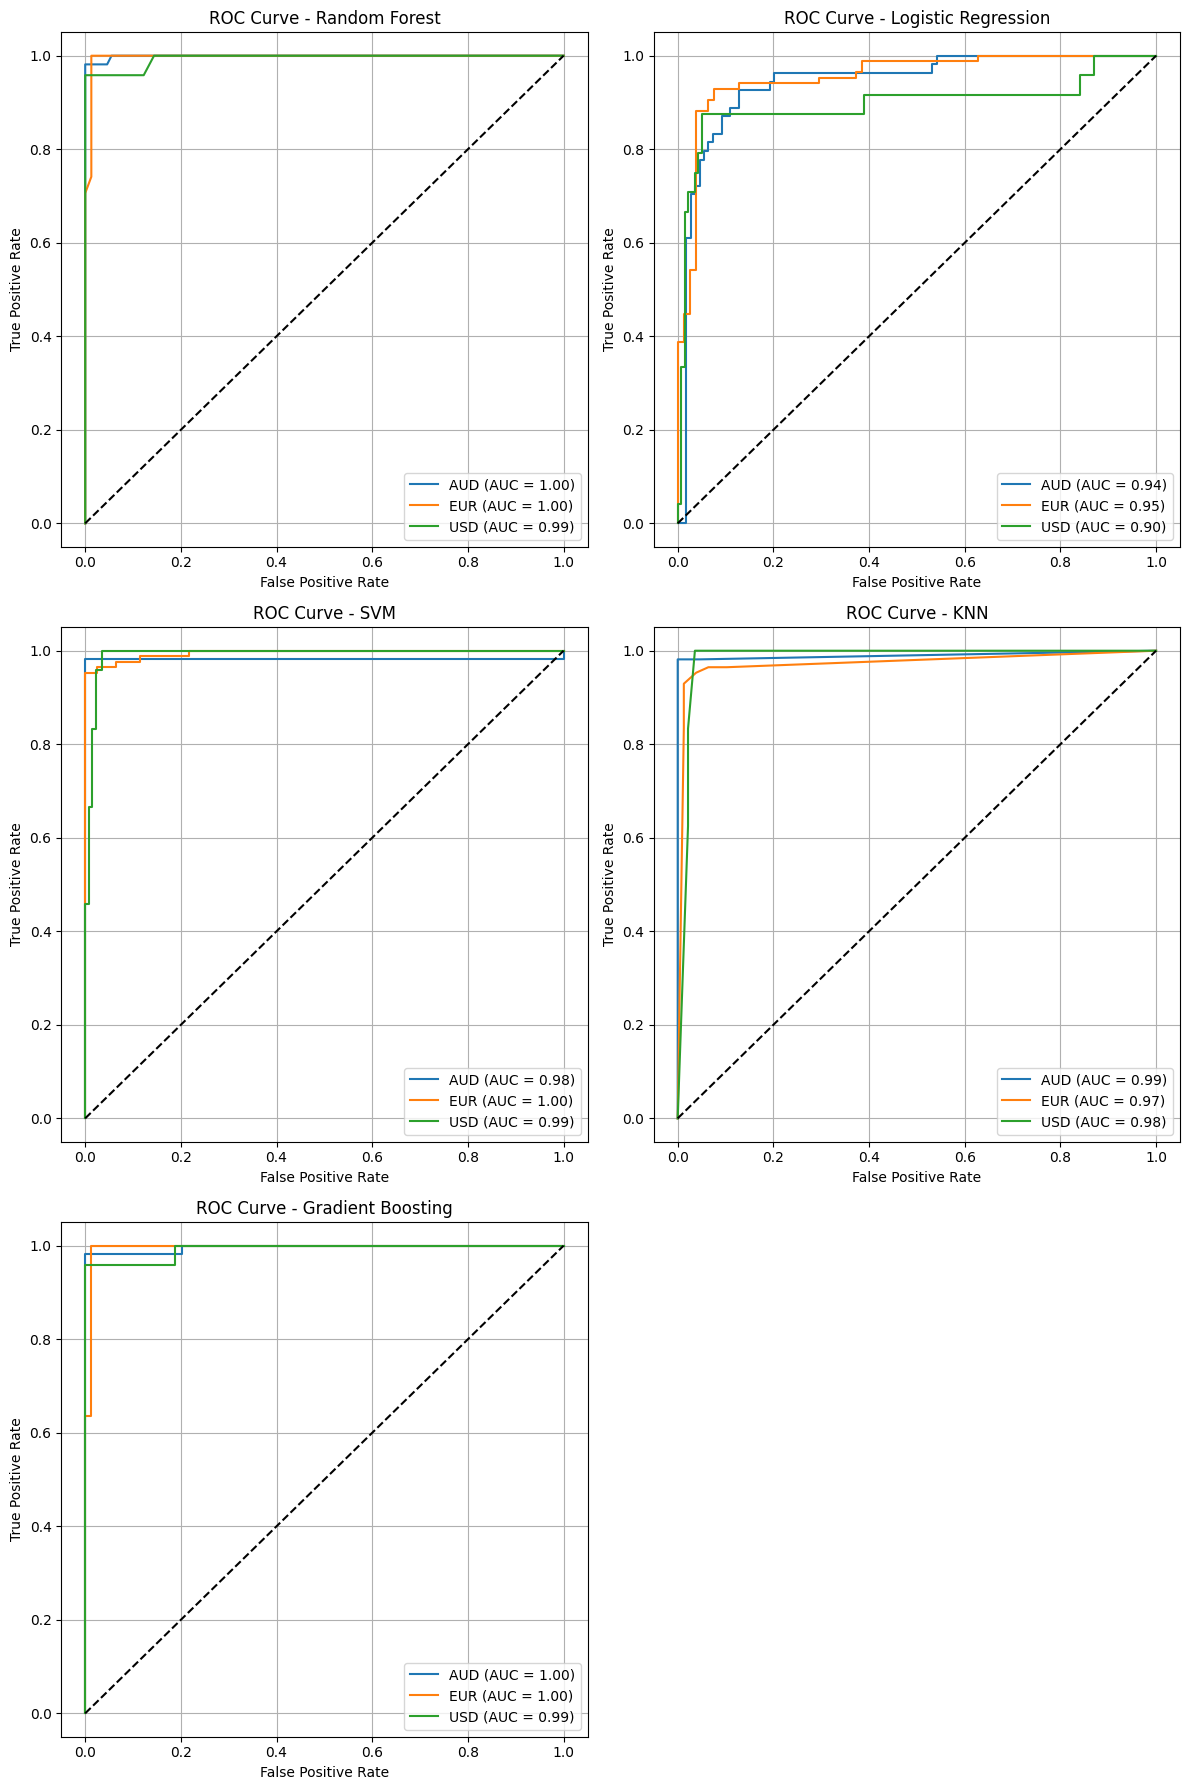

In [10]:
# Define models
models = {
    "Random Forest": RandomForestClassifier(n_estimators=100, random_state=42),
    "Logistic Regression": LogisticRegression(max_iter=1000, random_state=42),
    "SVM": SVC(probability=True, random_state=42),
    "KNN": KNeighborsClassifier(n_neighbors=5),
    "Gradient Boosting": GradientBoostingClassifier(random_state=42)
}

# Binarize the labels
classes = np.unique(y_train)
y_test_bin = label_binarize(y_test, classes=classes)
n_classes = len(classes)

# Create subplots (adjust rows and cols depending on number of models)
n_models = len(models)
cols = 2
rows = (n_models + 1) // cols

fig, axes = plt.subplots(rows, cols, figsize=(12, 6 * rows))
axes = axes.flatten()

for idx, (name, model) in enumerate(models.items()):
    model.fit(X_train_scaled, y_train)
    y_pred_prob = model.predict_proba(X_test_scaled)

    ax = axes[idx]
    for i in range(n_classes):
        fpr, tpr, _ = roc_curve(y_test_bin[:, i], y_pred_prob[:, i])
        roc_auc = auc(fpr, tpr)
        ax.plot(fpr, tpr, label=f'{classes[i]} (AUC = {roc_auc:.2f})')

    ax.plot([0, 1], [0, 1], 'k--')
    ax.set_xlim([-0.05, 1.05])
    ax.set_ylim([-0.05, 1.05])
    ax.set_title(f'ROC Curve - {name}')
    ax.set_xlabel('False Positive Rate')
    ax.set_ylabel('True Positive Rate')
    ax.legend(loc='lower right')
    ax.grid(True)

# Remove empty subplots if any
for j in range(idx + 1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()

We can see that Random Forest and Gradient Boosting are the best from all the other models. Let's futher see that by doing another graph on a couple more parameters. 

                     Accuracy  Precision    Recall  F1-Score       AUC
Random Forest        0.987730   0.987801  0.987730  0.987719  0.996659
Logistic Regression  0.871166   0.869358  0.871166  0.869211  0.931283
SVM                  0.963190   0.965621  0.963190  0.963845  0.989470
KNN                  0.957055   0.958724  0.957055  0.957636  0.982351
Gradient Boosting    0.981595   0.981595  0.981595  0.981595  0.994598


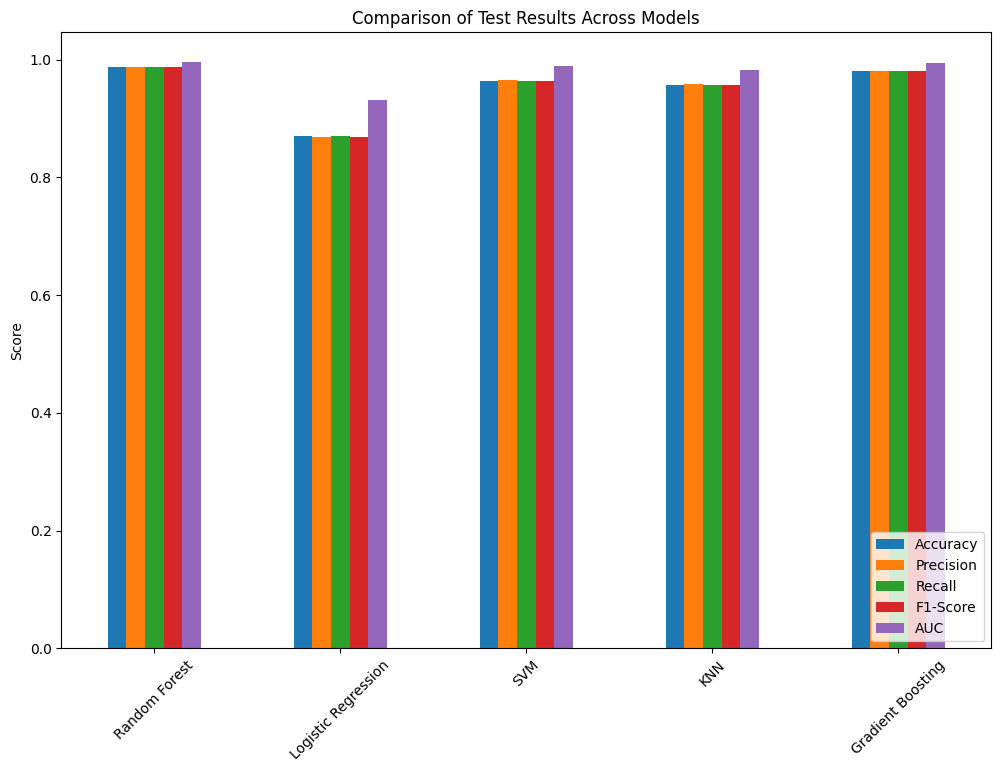

In [11]:
test_results = {}

for name, clf in models.items():
    # Predict on the test set
    y_pred_test = clf.predict(X_test_scaled)
    y_pred_prob_test = clf.predict_proba(X_test_scaled)
    
    # Calculate metrics
    accuracy_test = accuracy_score(y_test, y_pred_test)
    precision_test = precision_score(y_test, y_pred_test, average='weighted')
    recall_test = recall_score(y_test, y_pred_test, average='weighted')
    f1_test = f1_score(y_test, y_pred_test, average='weighted')
    
    # Calculate AUC for each class and average
    auc_scores_test = []
    for i, currency in enumerate(classes):
        fpr_test, tpr_test, _ = roc_curve(y_test_bin[:, i], y_pred_prob_test[:, i])
        auc_scores_test.append(auc(fpr_test, tpr_test))
    avg_auc_test = np.mean(auc_scores_test)
    
    # Store results
    test_results[name] = {
        'Accuracy': accuracy_test,
        'Precision': precision_test,
        'Recall': recall_test,
        'F1-Score': f1_test,
        'AUC': avg_auc_test
    }

# Display test results
test_results_df = pd.DataFrame(test_results).T
print(test_results_df)

# Plot comparison
test_results_df.plot(kind='bar', figsize=(12, 8))
plt.title("Comparison of Test Results Across Models")
plt.ylabel("Score")
plt.xticks(rotation=45)
plt.legend(loc='lower right')
plt.show()

As we can see, the Random Forest and Gradient Boosting are almost identical. Let's further test these models to se which one is doing a better job.

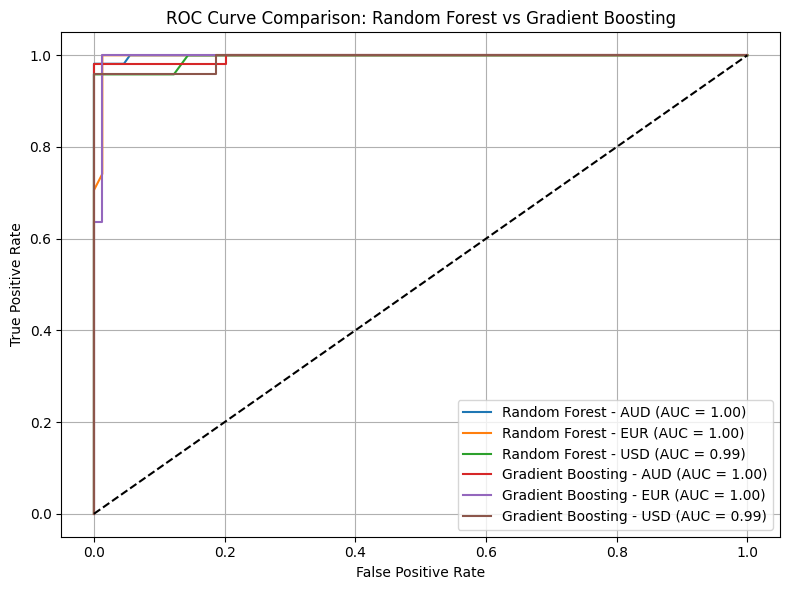

In [12]:
# Overlay ROC for direct comparison
plt.figure(figsize=(8,6))
for model_name in ["Random Forest", "Gradient Boosting"]:
    model = models[model_name]
    model.fit(X_train_scaled, y_train)
    y_pred_prob = model.predict_proba(X_test_scaled)

    for i in range(n_classes):
        fpr, tpr, _ = roc_curve(y_test_bin[:, i], y_pred_prob[:, i])
        roc_auc = auc(fpr, tpr)
        plt.plot(fpr, tpr, label=f'{model_name} - {classes[i]} (AUC = {roc_auc:.2f})')

plt.plot([0, 1], [0, 1], 'k--')
plt.title('ROC Curve Comparison: Random Forest vs Gradient Boosting')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc='lower right')
plt.grid(True)
plt.tight_layout()
plt.show()

Still looks very simmilar, Let's try something else.

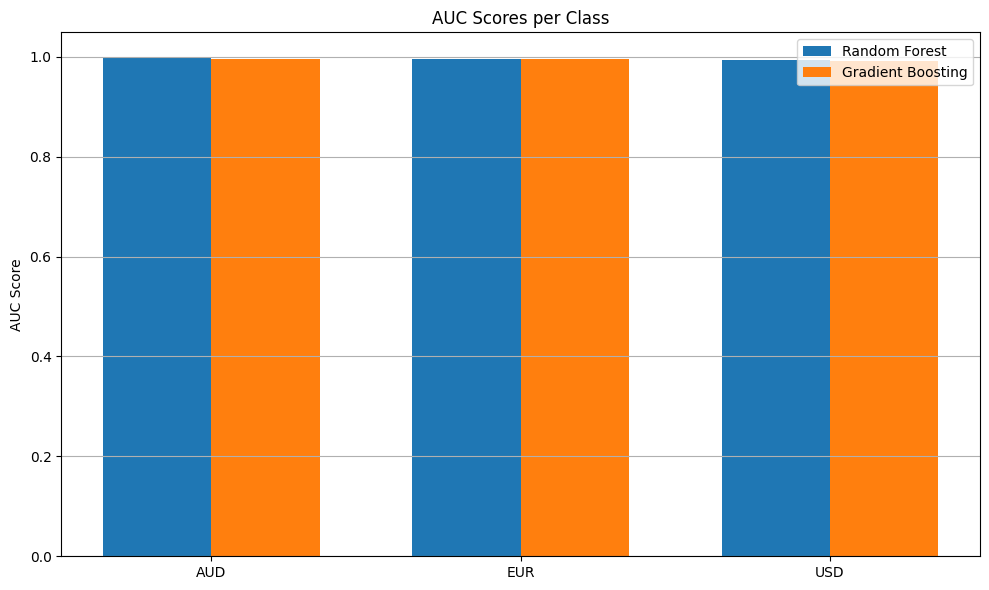

In [13]:
# AUC summary per class
auc_scores = {model_name: [] for model_name in ["Random Forest", "Gradient Boosting"]}

for model_name in auc_scores:
    model = models[model_name]
    model.fit(X_train_scaled, y_train)
    y_pred_prob = model.predict_proba(X_test_scaled)
    
    for i in range(n_classes):
        fpr, tpr, _ = roc_curve(y_test_bin[:, i], y_pred_prob[:, i])
        roc_auc = auc(fpr, tpr)
        auc_scores[model_name].append(roc_auc)

# Bar plot
x = np.arange(n_classes)
width = 0.35
fig, ax = plt.subplots(figsize=(10,6))
bars1 = ax.bar(x - width/2, auc_scores["Random Forest"], width, label='Random Forest')
bars2 = ax.bar(x + width/2, auc_scores["Gradient Boosting"], width, label='Gradient Boosting')

ax.set_xticks(x)
ax.set_xticklabels(classes)
ax.set_ylabel('AUC Score')
ax.set_title('AUC Scores per Class')
ax.legend()
ax.grid(True, axis='y')
plt.tight_layout()
plt.show()

Since we see the two models are very simmilar we will try a new approach. We will re-test them to see which one comes on top. We will run T-test and Wilcoxon test on the rest with some random seeds.

In [14]:
# Statistical comparison of AUCs between Random Forest and Gradient Boosting
seeds = [1, 5, 10, 42, 99]
rf_aucs = []
gb_aucs = []

classes = np.unique(y_train)
y_test_bin = label_binarize(y_test, classes=classes)

for seed in seeds:
    # Random Forest
    rf = RandomForestClassifier(n_estimators=100, random_state=seed)
    rf.fit(X_train, y_train)
    rf_probs = rf.predict_proba(X_test)
    rf_auc = roc_auc_score(y_test_bin, rf_probs, average='macro', multi_class='ovr')
    rf_aucs.append(rf_auc)

    # Gradient Boosting
    gb = GradientBoostingClassifier(random_state=seed)
    gb.fit(X_train, y_train)
    gb_probs = gb.predict_proba(X_test)
    gb_auc = roc_auc_score(y_test_bin, gb_probs, average='macro', multi_class='ovr')
    gb_aucs.append(gb_auc)

# Results
print(f"Random Forest AUCs: {rf_aucs}")
print(f"Gradient Boosting AUCs: {gb_aucs}")

# Statistical tests
t_stat, p_val_t = ttest_rel(rf_aucs, gb_aucs)
w_stat, p_val_w = wilcoxon(rf_aucs, gb_aucs)

print(f"Paired t-test: t={t_stat:.3f}, p={p_val_t:.3f}")
print(f"Wilcoxon test: w={w_stat:.3f}, p={p_val_w:.3f}")

Random Forest AUCs: [np.float64(0.9947470118793826), np.float64(0.9956542299336116), np.float64(0.994248126390378), np.float64(0.9966585070235608), np.float64(0.9960078425052911)]
Gradient Boosting AUCs: [np.float64(0.9945473354574029), np.float64(0.9945473354574029), np.float64(0.9945473354574029), np.float64(0.9945473354574029), np.float64(0.9945473354574029)]
Paired t-test: t=2.115, p=0.102
Wilcoxon test: w=2.000, p=0.188


Let's continue with our statistical analysis:

In [15]:
X_full = np.vstack((X_train, X_test))
y_full = np.concatenate((y_train, y_test))

skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

rf_aucs = []
gb_aucs = []

classes = np.unique(y_full)

for train_idx, test_idx in skf.split(X_full, y_full):
    X_tr, X_te = X_full[train_idx], X_full[test_idx]
    y_tr, y_te = y_full[train_idx], y_full[test_idx]
    
    y_te_bin = label_binarize(y_te, classes=classes)

    # Random Forest
    rf = RandomForestClassifier(n_estimators=100, random_state=42)
    rf.fit(X_tr, y_tr)
    rf_probs = rf.predict_proba(X_te)
    rf_auc = roc_auc_score(y_te_bin, rf_probs, average='macro', multi_class='ovr')
    rf_aucs.append(rf_auc)

    # Gradient Boosting
    gb = GradientBoostingClassifier(random_state=42)
    gb.fit(X_tr, y_tr)
    gb_probs = gb.predict_proba(X_te)
    gb_auc = roc_auc_score(y_te_bin, gb_probs, average='macro', multi_class='ovr')
    gb_aucs.append(gb_auc)

# Statistical test
print(f"RF AUCs: {rf_aucs}")
print(f"GB AUCs: {gb_aucs}")

RF AUCs: [np.float64(0.977574704352198), np.float64(0.9906864257718597), np.float64(0.9998491704374057), np.float64(0.999886736889795), np.float64(0.997814686689205)]
GB AUCs: [np.float64(0.993528318796861), np.float64(0.9898521378283925), np.float64(0.9991484640342025), np.float64(0.999633024851426), np.float64(0.9980445702404976)]


Let's see how much does these models disagree

In [16]:
rf_preds = rf.predict(X_test)
gb_preds = gb.predict(X_test)

disagreements = rf_preds != gb_preds
print(f"Disagreements: {np.sum(disagreements)} / {len(y_test)}")

# See examples where one is right and the other wrong
for i in np.where(disagreements)[0][:5]:
    print(f"Index {i}: True = {y_test[i]}, RF = {rf_preds[i]}, GB = {gb_preds[i]}")


Disagreements: 0 / 163


c:\Users\Menashe Lorenzi\GitHUB_projects\Multi-Exchange-Stock-Quote-Classifier\.venv\Lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(
c:\Users\Menashe Lorenzi\GitHUB_projects\Multi-Exchange-Stock-Quote-Classifier\.venv\Lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but GradientBoostingClassifier was fitted without feature names
  warnings.warn(


Wow! they agree on everything. Let's do Calibration curve to see which one is more reliable.

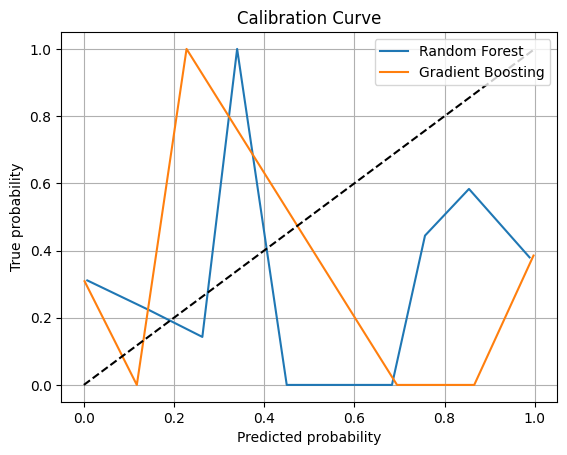

In [17]:
prob_true_rf, prob_pred_rf = calibration_curve(y_test_bin.ravel(), rf_probs.ravel(), n_bins=10)
prob_true_gb, prob_pred_gb = calibration_curve(y_test_bin.ravel(), gb_probs.ravel(), n_bins=10)

plt.plot(prob_pred_rf, prob_true_rf, label='Random Forest')
plt.plot(prob_pred_gb, prob_true_gb, label='Gradient Boosting')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel("Predicted probability")
plt.ylabel("True probability")
plt.title("Calibration Curve")
plt.legend()
plt.grid(True)
plt.show()

We can see Random Forest is more reliable. Let's make it harder for him to lean:

we will create a new data using generated test samples.

In [18]:
# Add Gaussian noise to simulate out-of-distribution test samples
X_test_perturbed = X_test.copy()
X_test_perturbed += np.random.normal(0, 0.1, X_test_perturbed.shape)

# Predict and evaluate
y_pred_perturbed = rf.predict(X_test_perturbed)
print("\n=== Performance on Noise-Perturbed Test Data ===")
print(classification_report(y_test, y_pred_perturbed))
print("Accuracy:", accuracy_score(y_test, y_pred_perturbed))



=== Performance on Noise-Perturbed Test Data ===
              precision    recall  f1-score   support

         AUD       1.00      0.98      0.99        54
         EUR       0.95      0.89      0.92        85
         USD       0.70      0.88      0.78        24

    accuracy                           0.92       163
   macro avg       0.88      0.92      0.90       163
weighted avg       0.93      0.92      0.92       163

Accuracy: 0.9202453987730062


c:\Users\Menashe Lorenzi\GitHUB_projects\Multi-Exchange-Stock-Quote-Classifier\.venv\Lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(


Random forest is doing really well. given that, let's see what are his important features:

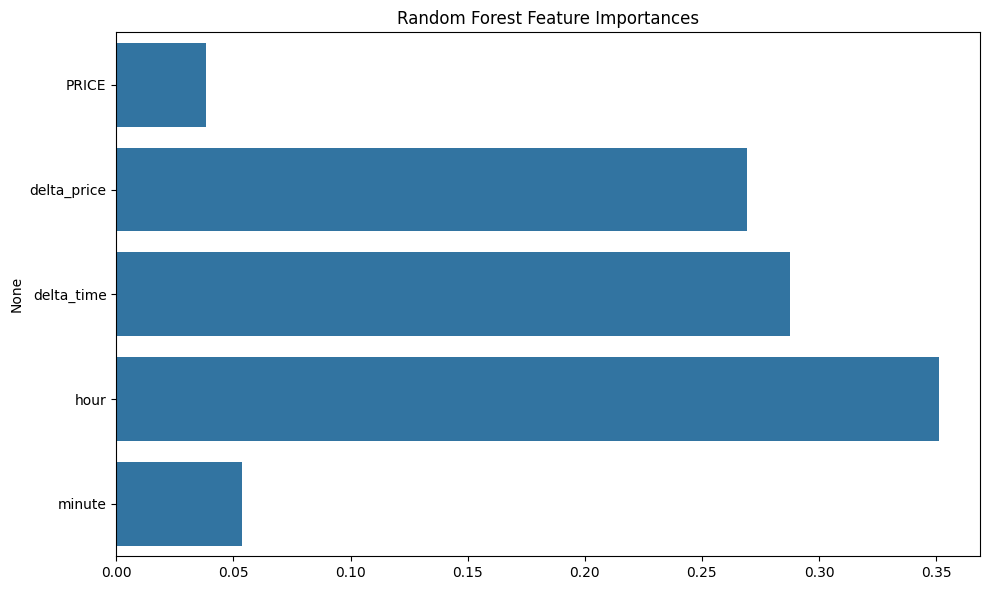

In [19]:
feature_importances = pd.Series(rf.feature_importances_, index=X_train.columns)
plt.figure(figsize=(10,6))
sns.barplot(x=feature_importances.values, y=feature_importances.index)
plt.title("Random Forest Feature Importances")
plt.tight_layout()
plt.show()

Let's do a confusion matrix

c:\Users\Menashe Lorenzi\GitHUB_projects\Multi-Exchange-Stock-Quote-Classifier\.venv\Lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(


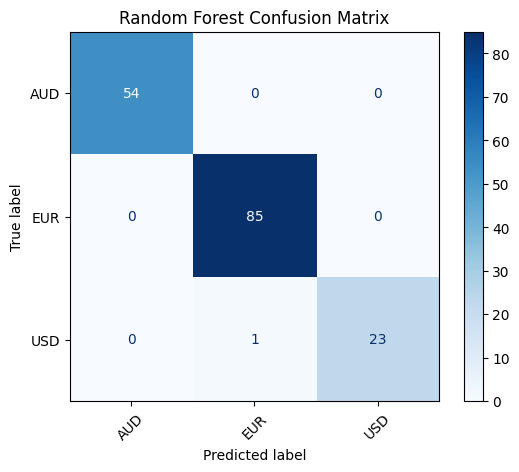

In [20]:
ConfusionMatrixDisplay.from_estimator(rf, X_test, y_test, cmap='Blues', xticks_rotation=45)
plt.title("Random Forest Confusion Matrix")
plt.show()

Let's make a function as told in the instructions:

In [21]:
def predict_currency(price, timestamp_str, reference_price=None, reference_time=None):
    timestamp = pd.to_datetime(timestamp_str)
    hour = timestamp.hour
    minute = timestamp.minute
    day_of_week = timestamp.dayofweek

    if reference_price is not None:
        delta_price = price - reference_price
    else:
        delta_price = 0.0

    if reference_time is not None:
        ref_time = pd.to_datetime(reference_time)
        delta_time = (timestamp - ref_time).total_seconds()
    else:
        delta_time = 0.0

    # Build a dictionary that matches the actual training columns
    feature_dict = {
        col: 0.0 for col in X_train.columns  # default values
    }

    # Fill in actual values
    for col in feature_dict:
        if col.upper() == 'PRICE':
            feature_dict[col] = price
        elif col.upper() == 'DELTA_PRICE':
            feature_dict[col] = delta_price
        elif col.upper() == 'DELTA_TIME':
            feature_dict[col] = delta_time
        elif col.upper() == 'HOUR':
            feature_dict[col] = hour
        elif col.upper() == 'MINUTE':
            feature_dict[col] = minute
        elif col.upper() == 'DAY_OF_WEEK':
            feature_dict[col] = day_of_week

    sample = pd.DataFrame([feature_dict])[X_train.columns]

    sample_scaled = scaler.transform(sample)
    probs = rf.predict_proba(sample_scaled)[0]
    best_idx = np.argmax(probs)
    return rf.classes_[best_idx], probs[best_idx]


# Example usage
currency, prob = predict_currency(
    price=1.2345,
    timestamp_str='2023-05-01 15:30:00',
    reference_price=1.2300,
    reference_time='2023-05-01 15:00:00'
)
print(f"Predicted currency: {currency} (Confidence: {prob:.2%})")


Predicted currency: USD (Confidence: 81.00%)


Let's show this function capabilities from the data set:

In [22]:
from random import sample
from datetime import datetime, timedelta

# Pick 10 random indexes from the test set
random_indexes = sample(range(len(X_test)), 10)

for i in random_indexes:
    # Extract the features
    row = X_test.iloc[i]
    price = row['PRICE']
    hour = int(row['hour'])
    minute = int(row['minute'])
    delta_price = row['delta_price']
    delta_time = row['delta_time']

    # Construct timestamps
    timestamp = datetime(2023, 5, 1, hour, minute)  # use any base date
    ref_timestamp = timestamp - timedelta(seconds=delta_time)

    # Predict
    currency, prob = predict_currency(
        price=price,
        timestamp_str=timestamp.strftime('%Y-%m-%d %H:%M:%S'),
        reference_price=price - delta_price,
        reference_time=ref_timestamp.strftime('%Y-%m-%d %H:%M:%S')
    )

    print(f"[#{i}] Predicted: {currency} (Confidence: {prob:.2%}) | Actual: {y_test.iloc[i]}")


[#125] Predicted: EUR (Confidence: 51.00%) | Actual: EUR
[#106] Predicted: USD (Confidence: 82.00%) | Actual: USD
[#155] Predicted: EUR (Confidence: 51.00%) | Actual: EUR
[#34] Predicted: USD (Confidence: 82.00%) | Actual: AUD
[#124] Predicted: USD (Confidence: 82.00%) | Actual: EUR
[#6] Predicted: USD (Confidence: 82.00%) | Actual: AUD
[#113] Predicted: EUR (Confidence: 69.00%) | Actual: EUR
[#122] Predicted: EUR (Confidence: 51.00%) | Actual: EUR
[#159] Predicted: EUR (Confidence: 76.00%) | Actual: EUR
[#135] Predicted: USD (Confidence: 84.00%) | Actual: AUD
